#BASIC INFORMATION (ReadMe)



**1.  About Jupyter Notebook and Google Colab**
- Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and text. Uses include: data cleaning and transformation, numerical simulation, statistical modeling, data visualization, machine learning etc.
- Google Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. 

**2.   About this lab**

- In this lab we will explore and use Melbourne housepricing dataset.  Each row in the dataset is a housing sale and columns are the features of the sold house/appartment.


- The goal is to predict the price of new sales. We will build two supervised models: regression models and artificial neural network. ML pipeline outlined in the theory part of the course will be followed. 


**3.  How to save own version of the Jupyter notebook**

Go to File and choose "Save a copy in Drive". It will be saved on your Google Drive.

**4.   How to run/execute cell of code**

Mark the cell,  press "Run" button on the left side of the cell or Ctrl+Shift tab through the code.


**5.  More info about dataset**
 - Data source: https://www.kaggle.com/anthonypino/melbourne-housing-market


 - Columns:
1. Suburb: Suburb
2. Address: Address
3. Rooms: Number of rooms
4. Price: Price in Australian dollars, AUD
5. Method: S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.
6. Type: br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.
7. SellerG: Real Estate Agent
8. Date: Date sold
9. Distance: Distance from CBD in Kilometres 
10. Regionname: General Region (West, North West, North, North east ...etc)
11. Propertycount: Number of properties that exist in the suburb
12. Bedroom2 : Scraped # of Bedrooms (from different source)
13. Bathroom: Number of Bathrooms
14. Car: Number of carspots
15. Landsize: Land Size in Metres
16. BuildingArea: Building Size in Metres
17. YearBuilt: Year the house was built
18. CouncilArea: Governing council for the area
19. Lattitude: Self explanitory
20. Longtitude: Self explanitory


#1) CLONE ENVIRONMENT & IMPORT LIBRARIES

##1.1. Get all the files
- Run the below code cell if the notebook is opened in Google Collab. It will clone the github repository to get all necessary files.

In [1]:
!git clone https://github.com/NordAxon/AI-For-Leaders.git

Cloning into 'AI-For-Leaders'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 121 (delta 19), reused 15 (delta 5), pack-reused 78
Receiving objects: 100% (121/121), 50.99 MiB | 1.85 MiB/s, done.
Resolving deltas: 100% (46/46), done.


## 1.2 Import libraries
- ML with Python offers a great deal of libraries.
- Read about some of the most used: https://hackernoon.com/top-10-libraries-in-python-to-implement-machine-learning-12602cf5dc61

- Lets import all the libraries we need to run the code and perform the analysis. Run the below code cell.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

import seaborn as sns

pd.set_option('display.max_columns', 100)
%load_ext autoreload
%autoreload 2

np.random.seed(1)

Using TensorFlow backend.


# 2) IMPORT RAW DATA

In [3]:
housing_df_original = pd.read_csv('AI-For-Leaders/data/melbourne-housing-market/Melbourne_housing.csv')
housing_df_original

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.80790,144.99340,Northern Metropolitan,4019.0
1,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.80930,144.99440,Northern Metropolitan,4019.0
2,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.80720,144.99410,Northern Metropolitan,4019.0
3,Abbotsford,16 Maugie St,4,h,NaN,SN,Nelson,6/08/2016,2.5,3067.0,3.0,2.0,2.0,400.0,220.0,2006.0,Yarra City Council,-37.79650,144.99650,Northern Metropolitan,4019.0
4,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,7/05/2016,2.5,3067.0,4.0,2.0,0.0,245.0,210.0,1910.0,Yarra City Council,-37.80240,144.99930,Northern Metropolitan,4019.0
5,Abbotsford,121/56 Nicholson St,2,u,NaN,PI,Biggin,7/11/2016,2.5,3067.0,2.0,2.0,1.0,4292.0,82.0,2009.0,Yarra City Council,-37.80780,144.99650,Northern Metropolitan,4019.0
6,Abbotsford,17 Raphael St,4,h,NaN,W,Biggin,7/11/2016,2.5,3067.0,6.0,2.0,0.0,230.0,147.0,1860.0,Yarra City Council,-37.80660,144.99360,Northern Metropolitan,4019.0
7,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,8/10/2016,2.5,3067.0,2.0,1.0,2.0,256.0,107.0,1890.0,Yarra City Council,-37.80600,144.99540,Northern Metropolitan,4019.0
8,Abbotsford,10 Valiant St,2,h,1097000.0,S,Biggin,8/10/2016,2.5,3067.0,3.0,1.0,2.0,220.0,75.0,1900.0,Yarra City Council,-37.80100,144.99890,Northern Metropolitan,4019.0
9,Abbotsford,2 Rich St,2,h,NaN,SP,Biggin,10/12/2016,2.5,3067.0,2.0,1.0,1.0,176.0,80.0,1925.0,Yarra City Council,-37.79980,144.99720,Northern Metropolitan,4019.0


In [4]:
# Size of the dataset (X, Y)
housing_df_original.shape

(13742, 21)

# 3) EXPLORE DATA & PRE-PROCESSING

##  3.1. Fill in empty/missing data

- In some of the columns we have NaN(Not a Number) values i.e. missing data.

- Many ML algorithms need data in all rows and columns so the NaNs have to be filled with something meaningful. E.g. "Landsize" will be filled with 0 to indicate that there is no land contained in the real estate sale. 



 


Let's first have a look at how many NaN values are present in each column. 
- Run the code cell below

In [5]:
print('Number of NaNs for every variable:')
print(pd.isnull(housing_df_original).sum())

Number of NaNs for every variable:
Suburb              0
Address             0
Rooms               0
Type                0
Price            3086
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car               232
Landsize         1602
BuildingArea        0
YearBuilt         504
CouncilArea         0
Lattitude           9
Longtitude          9
Regionname          0
Propertycount       0
dtype: int64


Lets clean and fill/replace missing/odd values
- Remove rows where there is no price
- Fill NaN values in columns BuildingArea, Rooms, Landsize, Car, Bathroom, Bedroom2 with 0
- For column YearBuilt, fill with the mean value of that column since the house being built at year 0 seems unlikely

In [6]:
housing_df_no_nan = housing_df_original.copy()

# Remove all rows with no price data
housing_df_no_nan = housing_df_no_nan[pd.notnull(housing_df_no_nan['Price'])]

# Replace NaN values with 0 values in columns BuildingArea, Rooms, Landsize, Car, Bathroom, Bedroom2 
housing_df_no_nan['BuildingArea'].fillna(0.0, inplace=True)
housing_df_no_nan['Rooms'].fillna(0.0, inplace=True)
housing_df_no_nan['Landsize'].fillna(0.0, inplace=True)
housing_df_no_nan['Car'].fillna(0.0, inplace=True)
housing_df_no_nan['Bathroom'].fillna(0.0, inplace=True)
housing_df_no_nan['Bedroom2'].fillna(0.0, inplace=True)

# Replace NaN values in YearBuilt column with mean value of that column
housing_df_no_nan['YearBuilt'].fillna(housing_df_no_nan['YearBuilt'].mean(), inplace=True)

print('Number of NaNs for every variable:')
print(pd.isnull(housing_df_no_nan).sum())

Number of NaNs for every variable:
Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        9
Longtitude       9
Regionname       0
Propertycount    0
dtype: int64


##**3.2. Plot variable correlations and histograms**

- Let's have a look at how different variables relate to each other and how the data is distributed. 
- The goal is to get insight in our dataset, understand how different columns relate to each other and look for outliers.
- Let pick some columns(variables) we think might be good predictors of price and scatter plot those against each other and as histograms along the diagonal. In a real project we would have plotted all variables in many different ways, but we try to restrict the time spent on this by only picking six variables.


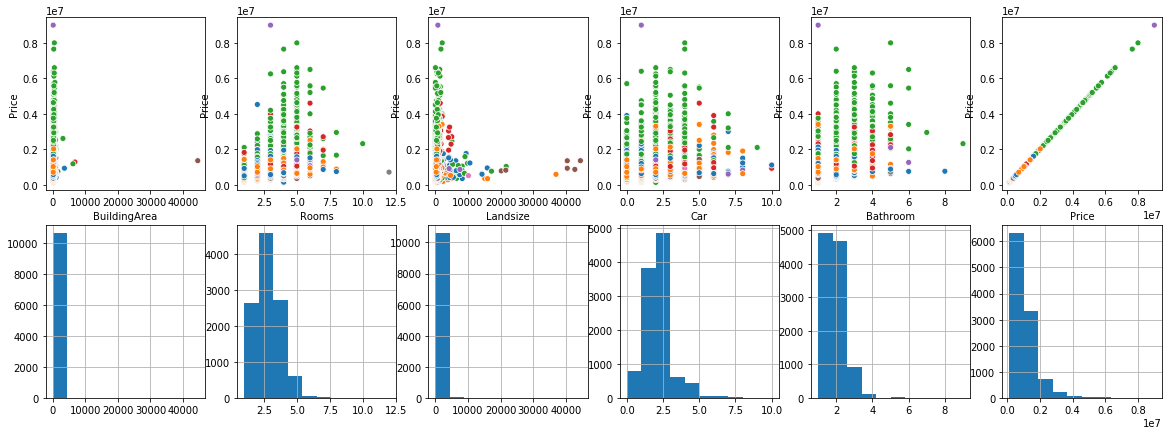

In [65]:
plot_str_arr = ['BuildingArea', 'Rooms', 'Landsize', 'Car', 'Bathroom']
f, axarr = plt.subplots(2, len(plot_str_arr)+1, figsize=(20,7))

i = 0
for plt_str in plot_str_arr + ['Price']:
    sns.scatterplot(x=plt_str, y="Price", hue="Regionname", data=housing_df_no_nan, ax=axarr[0,i], legend=False)
    housing_df_no_nan[plt_str].hist(ax=axarr[1,i])
    i += 1
    
f.canvas.set_window_title('Scatter Plots and Histograms')

## 3.3. Remove outliers

- Outliers are datapoints located far from the other data points, these come with a risk of skewing the models and therefore we want to remove these. 

- In the plots above it seems like we have outliers in some of the columns. We will have a deeper look at some columns which seem to contain outliers. 

- Run the cell below to see a plot of BuildingArea vs Price where it is clear that we have some data points which are far away from the others. 

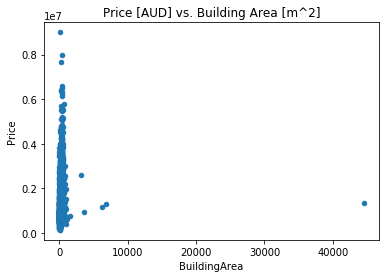

In [8]:
housing_df_no_nan.plot.scatter('BuildingArea', 'Price', title='Price [AUD] vs. Building Area [m^2]')

1.   Set clip-offs:
>*  Building area = 500 m^2 (all data points larger than 500 will be set to 500)
>*  Price= 4 000 000 AUD
2. Plot again! 

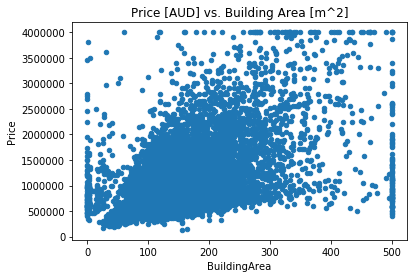

In [9]:
housing_clipped = housing_df_no_nan.copy()
housing_clipped['BuildingArea'] = housing_clipped['BuildingArea'].clip(0, 500)
housing_clipped['Price'] = housing_clipped['Price'].clip(0, 4e6)
housing_clipped.plot.scatter('BuildingArea', 'Price', title='Price [AUD] vs. Building Area [m^2]')

### Assignment 1:

-  Plot "Landsize" (unit=m^2) vs "Price" in the empty cell below. 
- Does it look like there are some outliers? If so, what could be a resonable cut-off? (Hint: Have a look above at the statistical printouts for Landsize)
-  Clip the data set to remove Landsize outliers, i.e replace the value of variable landsize_max with a resonable number. Plot again!

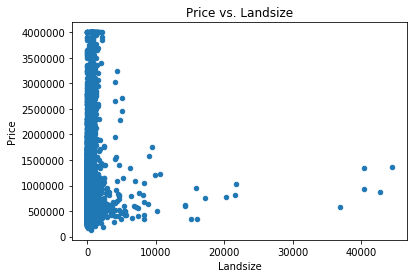

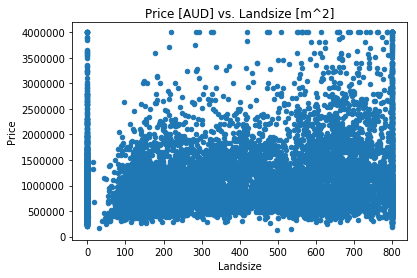

In [10]:
# ENTER CODE HERE


# SOLUTION (filter out or clip outliers for Landsize)
housing_clipped.plot.scatter('Landsize', 'Price', title='Price vs. Landsize')
landsize_max = 800
housing_clipped_l = housing_clipped.copy()
housing_clipped_l['Landsize'] = housing_clipped['Landsize'].clip(0, landsize_max)
housing_clipped_l.plot.scatter('Landsize', 'Price', title='Price [AUD] vs. Landsize [m^2]')



## 3.4 Plot histograms for indicative columns
- Lets have a look more closely at the variables we think could be interesting by plotting seperate and larger histograms.

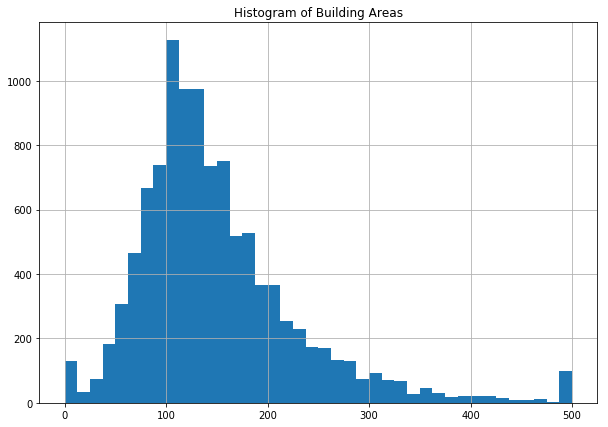

In [11]:
housing_clipped_l['BuildingArea'].hist(bins=40, figsize=(10,7))
plt.title('Histogram of Building Areas');
# TODO: Make it better

### Assignment 2:

- Create a histogram of variable Price in the empty cell below.

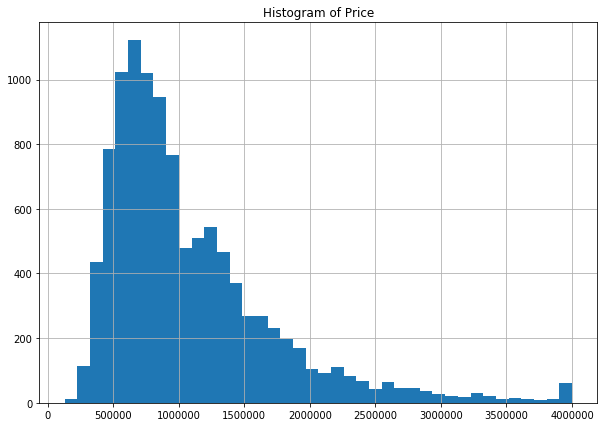

In [12]:
# CODE HERE


# SOLUTION
housing_clipped_l['Price'].hist(bins=40, figsize=(10,7))
plt.title('Histogram of Price');

## 3.5 Price for different regions
- We are also hypothesising that the property location will have an impact on price. 
- Below a plot will be made to get a feel for how different locations might affect the price. 

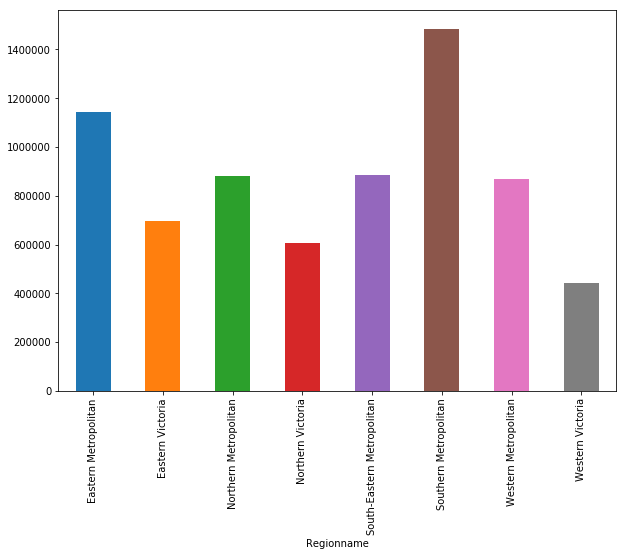

In [13]:
plt.figure(figsize=(10,7))
housing_clipped_l.groupby('Regionname')['Price'].mean().plot.bar();

### Assignment 3: 
- Plot Price for different CouncilArea

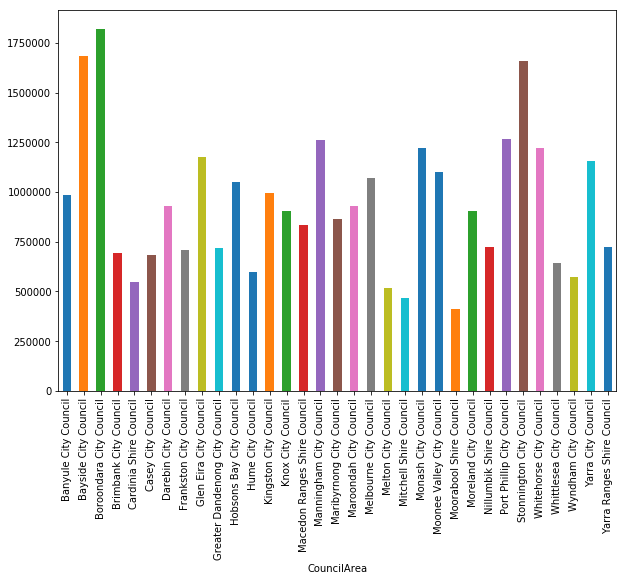

In [14]:
# CODE HERE

# SOLUTION
plt.figure(figsize=(10,7))
housing_clipped_l.groupby('CouncilArea')['Price'].mean().plot.bar();

# 4) MODELLING: SIMPLE DIMENSIONAL LINEAR REGRESSION

- We are getting a feeling for what the data looks like, so now we might try a first model for predicting price. 
- The simple linear regression, one predictor variable (X) and one output variable (Y)  is very commonly used model. 

- We pick BuildingArea as a predictor to begin with since there seem to be a correlation between BuildingArea and Price according to our exploration. 

- The goal is to find all of the weights, $w_i$, in the following linear regression model. **Lookup slide XXXX for better explanation!!!!**


> $y = w_0 + w_1x_1$







## 4.1 Split dataset, pick algorithm, train model



/Users/markusmalmros/Desktop/NordAxon/AI-For-Leaders/course_env/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


[1080649.19802631 1199387.44156026  749878.37675317 ...  953429.65138279
  906782.48428017  911023.13583495]
[4240.65155478]


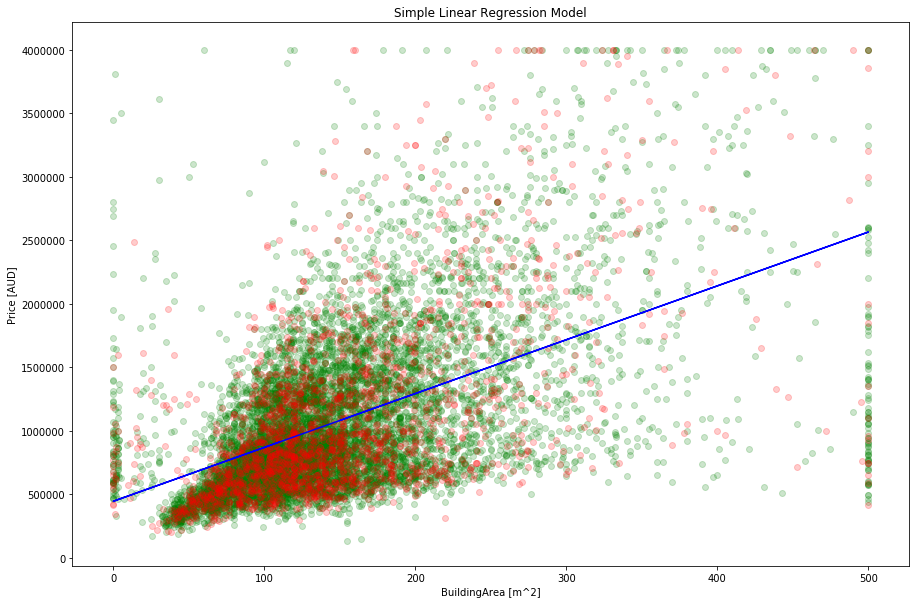

In [17]:
# Set up input (x) and output (y) variables
x = housing_clipped_l[['BuildingArea']]
y = housing_clipped_l['Price']

# Split into test and train data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

# Set up and train simple linear regression model
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

# Perform predictions on testset
y_pred_simple = regr.predict(x_test)

print (y_pred_simple)


### Plot results ###

# Prepare plotting figure and axes
plt.figure(figsize=(15,10));
plt.title('Simple Linear Regression Model');
plt.xlabel('BuildingArea [m^2]', fontsize=10)
plt.ylabel('Price [AUD]', fontsize=10)

# Plot training data in green color
plt.scatter(x_train.values, y_train.values, color='green', alpha=0.2)
# Plot test data in red color
plt.scatter(x_test.values, y_test.values, color='red', alpha=0.2)

# Plot the simple regression line based on test data in blue color
plt.plot(x_test, y_pred_simple, 'b')

print (regr.coef_)


## 4.2 Model evaluation
The error value will be compared to a baseline error which is the error if the prediction is just the mean of previous house values. 

In [18]:
# Evaluate Results

mean_absolute_error_simple = str(int((y_pred_simple - y_test).abs().mean()))
mean_baseline_error = str(int((y_train.mean() - y_test).abs().mean()))



print('* Mean Absolute Error with Simple Linear Regression = ' + mean_absolute_error_simple)
print('* Mean Baseline Error: ' + mean_baseline_error)

if mean_absolute_error_simple < mean_baseline_error:
    print ('\nMean Absolute Error with "Simple Linear Regression" is smaller then "Mean Baseline Error". Good!')

* Mean Absolute Error with Simple Linear Regression = 412457
* Mean Baseline Error: 494476

Mean Absolute Error with "Simple Linear Regression" is smaller then "Mean Baseline Error". Good!


# 5) MODELLING: MULTI-DIMENSIONAL LINEAR REGRESSION

- In order to increase the predictive power, i.e. to get a more accurate model, more information can be added to the model. 
- One way of doing that is by adding more input variables to the model. 
- Variables that could be tried are BuildingArea, Rooms, LandSize, Car. 


> $y = w_0 + w_1x_1 + w_2x_2 + \dots$


## 5.1 Split dataset, pick algorithm, train model

***** Regression Coefficients: *****
4
BuildingArea = 3248.744475212759
Rooms = 136663.94513063988
Landsize = 120.45151093490733
Car = -31044.995012599786


"\nprint x_test['BuildingArea'].shape\nprint y_pred_multidim.shape\nprint x_test['BuildingArea']\nprint y_pred_multidim\n\n# Transform data\nscaler = MinMaxScaler()\nx_train_scaled = scaler.fit_transform(x_train)\nx_test_scaled = scaler.transform(x_test)\ny_train_scaled = scaler.fit_transform(y_train.values.reshape(len(y_train),1))\ny_test_scaled = scaler.transform(y_test.values.reshape(len(y_test),1))\n\nprint x_train_scaled\nprint y_train_scaled\n"

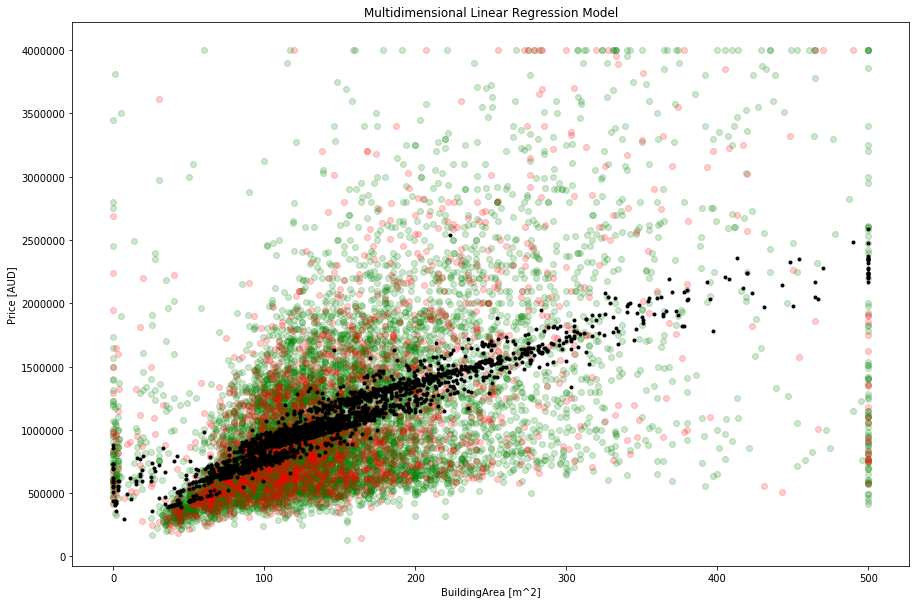

In [20]:
# Pick our in-variables i.e. features
features_input_list = ['BuildingArea', 'Rooms','Landsize', 'Car']
x = housing_clipped_l[features_input_list]
y = housing_clipped_l['Price']

# Split into test and train data
x_train_multidim, x_test_multidim, y_train_multidim, y_test_multidim = train_test_split(x, y, test_size=0.2)

# Set up and train regression model
regr_multidim = linear_model.LinearRegression()
regr_multidim.fit(x_train_multidim, y_train_multidim)

# Perform predictions
y_pred_multidim = regr_multidim.predict(x_test_multidim)

######### Plot results ##########

# Prepare plotting figure and axes
plt.figure(figsize=(15,10));
plt.title('Multidimensional Linear Regression Model');
plt.xlabel('BuildingArea [m^2]', fontsize=10)
plt.ylabel('Price [AUD]', fontsize=10)

# Plot training data in green color
plt.scatter(x_train_multidim['BuildingArea'].values, y_train_multidim.values, color='green', alpha=0.2)
# Plot test data in red color
plt.scatter(x_test_multidim['BuildingArea'].values, y_test_multidim.values, color='red', alpha=0.2)

# Plot the multidim regression line based on test data in black color
plt.plot(x_test_multidim['BuildingArea'], y_pred_multidim, 'k.')
#plt.plot(x_test_multidim['BuildingArea'], y_pred_simple, 'b')


# Print regression coefficients, w
print('***** Regression Coefficients: *****')
i=0
print(len(features_input_list))
while i<len(features_input_list):
    print(features_input_list[i] + ' = ' + str(regr_multidim.coef_[i]))
    i+=1


"""
print x_test['BuildingArea'].shape
print y_pred_multidim.shape
print x_test['BuildingArea']
print y_pred_multidim

# Transform data
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(len(y_train),1))
y_test_scaled = scaler.transform(y_test.values.reshape(len(y_test),1))

print x_train_scaled
print y_train_scaled
"""

## 5.2 Model evaluation

In [21]:
mean_absolute_error_multidim = str(int((y_pred_multidim - y_test_multidim).abs().mean()))
print('* Mean Absolute Error with Multi-Dimensional Linear Regression = ' + mean_absolute_error_multidim)
print('* Mean Absolute Error with Simple Linear Regression = ' + mean_absolute_error_simple)

if mean_absolute_error_multidim < mean_absolute_error_simple:
    print ('\n Mean Absolute Error with "Multi-Dimensional Linear Regression" is smaller then with "Simple Linear Regression". \n Good, our regression model is improving!')

* Mean Absolute Error with Multi-Dimensional Linear Regression = 386326
* Mean Absolute Error with Simple Linear Regression = 412457

 Mean Absolute Error with "Multi-Dimensional Linear Regression" is smaller then with "Simple Linear Regression". 
 Good, our regression model is improving!


### Assignment 4:
- Test your multidimensiona model with different input parameters by picking them from the list of 20 available and compare results? 

- Hint: Modify first line of code under section 5.2 (add/remove) rerun the model and evaluate!

# 6) MODELLING: ARTIFICAL NEURAL NETWORK


## Split dataset, pick algorithm, train & evaluate model

The code in the following cell transforms data, builds a neural network and evaluates results of predictions from the neural net.

Good reading about different steps with Keras:
https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [77]:
# from numpy.random import seed
# seed(1)
# Filter out the wanted columns

def run_neural_network(x, y, n_epochs=10, layer_list=[100,20]):
    x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(x, y, train_size=0.5, test_size=0.5)

    # Scale the data
    scaler = MinMaxScaler()
    x_train_nn = scaler.fit_transform(x_train_nn)
    x_test_nn = scaler.transform(x_test_nn)
    y_train_nn = scaler.fit_transform(y_train_nn.values.reshape(len(y_train_nn),1))
    y_test_nn= scaler.transform(y_test_nn.values.reshape(len(y_test_nn),1))
    
    print (' x_train_nn = ')
    print (x_train_nn)
    print (x_train_nn.shape)

    print ('\n y_train_nn = ')
    print (y_train_nn)
    print (y_train_nn.shape)

   
    # Define the NN structure (with Keras): 3 layers with (100,20,1) neurons, train.shape[1] input variables
    model = Sequential()
    model.add(Dense(layer_list[0], input_dim=x_train_nn.shape[1], activation='relu'))
    for layer_size in layer_list[1:]:
        model.add(Dense(layer_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # Plot model summary
    print(model.summary())
    
    # Compile model 
    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])

    # Train the model
    history = model.fit(x_train_nn, y_train_nn, epochs=n_epochs, verbose=0, validation_data=(x_test_nn, y_test_nn))

    # Make a prediction
    y_pred_nn = model.predict(x_test_nn)[:,0]
    
    # Show the inputs and predicted outputs
    y_pred_nn = scaler.inverse_transform(y_pred_nn.reshape(len(y_pred_nn),1))
    y_test_nn = scaler.inverse_transform(y_test_nn)
    
    print ('\n y_pred_nn = ')
    print (y_pred_nn)
    print ('\n y_test_nn = ')
    print (y_test_nn)

    # Evaluate results
    mean_error = (pd.Series(y_pred_nn[:,0]) - y_test_nn[:,0]).abs().mean()
    print('Mean Absolute Test Error: ' + str(mean_error))

    # Plot error over training time
    plt.figure(figsize=(10,7))
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('Model Loss')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    

 x_train_nn = 
[[0.104      0.         0.         0.1       ]
 [0.49       0.27272727 0.71625    0.2       ]
 [0.246      0.18181818 0.4275     0.1       ]
 ...
 [0.39       0.18181818 0.83125    0.1       ]
 [0.442      0.27272727 0.98875    0.2       ]
 [0.326      0.27272727 1.         0.2       ]]
(5328, 4)

 y_train_nn = 
[[0.06952701]
 [0.15223572]
 [0.26466787]
 ...
 [0.37451538]
 [0.65107263]
 [0.54200052]]
(5328, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 5)                 25        
_________________________________________________________________
dense_46 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_48 (Dense)             (None, 1)     

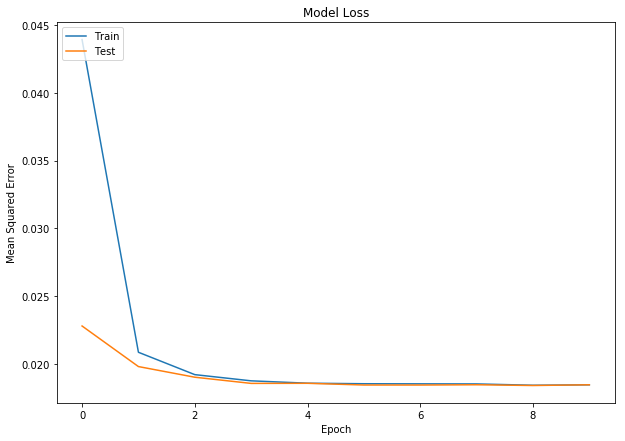

In [81]:
# Pick in-variables i.e. features
features_input_list = ['BuildingArea', 'Rooms', 'Landsize', 'Car']
x = housing_clipped_l[features_input_list]
y = housing_clipped_l['Price']

# Call/execute neural network
run_neural_network(x,y, 10, [5, 2])

## Assignment 5:
Try different number of training epochs by adjusting the code above.
-  What happens with the loss for a higher amount of training epochs(time)?


ANSWER HERE (doubleclick):



## Assignment 6:
Try different sizes of the network by adjusting the code above. Try out the following network configurations while watching the mean absolute error for test and train data. The lists below are denoted such that the first entry represents the number of neurons in the first layer and so on. 
- Configuration 1: [5, 2]
- Configuration 2: [100, 20]  (Increasing the number or neurons)
- Configuration 3: [1000, 100] (Increasing the number or neurons even more)
- Configuration 4: [5, 5, 5, 2] (More layers) (the term deep learning originates from using many layers)
- Configuration 5: [500, 500, 200] (Larger network)
- Configuration 6: You can test your own configuration if you want to. 

> 6.1. What are the results when adding more layers? <br>
> 6.2. What are the results when adding more neurons? <br>
> 6.3. When is there a difference between train and test data in absolute error? 

ANSWER HERE (doubleclick):

## Assignment 7: 
Trying adding more features  by adjusting the code above.
-  Which columns could be useful for providing more predictive power?

ANSWER HERE (doubleclick):

## *Questions:*


1.   Which of the different models performed best? Why?
2.   Why does a well tuned neural network perform better than a linear regression model?
3.   What could be done to increase predictive power?
4.   Which additional data do you think would make a large differce in predictive power?
5.   What was the lowest mean square error you got?




ANSWER HERE (doubleclick):

1. 
2. 
3. 
4. 
5. 




## Extra code and assignments improving our NN
Adding more features:
- Let's look at the data to see what we can do with the data to create columns which are more easily readable for a ML algorithm and how we can provide more information from the data we have. 
- Lets try and make the predictive model as good as possible by adding more features such as location and age of property. 

In [27]:
# CODE HERE:


### Assignment 8: 
Modify code below to include CouncilArea in addition to Regionname 

In [29]:
# One-hot encoding of Region
one_hot_region = pd.get_dummies(housing_clipped_l.Regionname, prefix='Regionname')
housing_df_feature = pd.concat([housing_clipped_l, one_hot_region], axis=1)
one_hot_region

,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0,0
8,0,0,1,0,0,0,0,0
10,0,0,1,0,0,0,0,0
11,0,0,1,0,0,0,0,0
12,0,0,1,0,0,0,0,0
14,0,0,1,0,0,0,0,0


### Adding house age as a feature
- Using the build year of a house directly as a feature is not good since most values will be around 2000. 
- A small difference in feature might be a big difference in actual house value; e.g. a house built 2017 is probably a lot more valuable than a house build 2007, but that is still a small percentual difference. The percentual difference between the age of 1 year and 11 years on the other hand gives a large difference. 
- We also log-transform the age to make it a bit more convenient for machine learning algorithms. 

Text(0.5,1,'Distribution After logarithm')

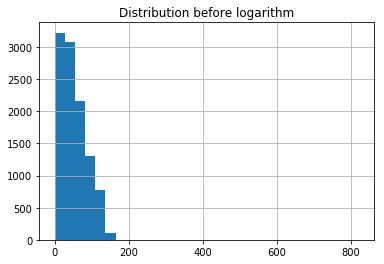

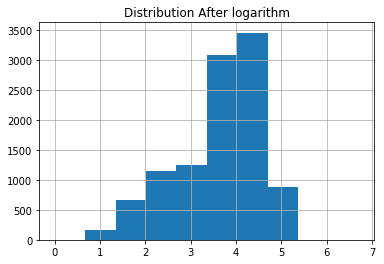

In [30]:
#(2018. - housing_df_feature['YearBuilt']).apply(lambda x: np.log(x))
housing_df_feature['YearBuilt'] = housing_df_feature['YearBuilt'].clip(0, 2018)
house_ages = pd.Series(np.log((1 + (2018. - housing_df_feature['YearBuilt']))))
(2018. - housing_df_feature['YearBuilt']).hist(bins=30)
plt.title('Distribution before logarithm')
housing_df_feature['Age'] = house_ages
plt.figure()
house_ages.hist()
plt.title('Distribution After logarithm')

### Trying NN with new features
With new features added it is time to train the neural network again, run the next cell and check the results. 

 x_train_nn = 
[[0.188      0.28571429 0.36       ... 0.         1.         0.        ]
 [0.16       0.28571429 0.         ... 1.         0.         0.        ]
 [0.218      0.28571429 0.35375    ... 0.         0.         0.        ]
 ...
 [0.48       0.42857143 0.75375    ... 0.         0.         0.        ]
 [0.052      0.28571429 0.65375    ... 0.         0.         0.        ]
 [0.166      0.14285714 0.1375     ... 1.         0.         0.        ]]
(5328, 13)

 y_train_nn = 
[[0.14473684]
 [0.15789474]
 [0.17368421]
 ...
 [0.25210526]
 [0.11473684]
 [0.16578947]]
(5328, 1)

 y_pred_nn = 
[[ 803773.06]
 [1420704.  ]
 [1008827.9 ]
 ...
 [ 966044.75]
 [1231597.6 ]
 [ 489797.1 ]]

 y_test_nn = 
[[880000.]
 [890000.]
 [510000.]
 ...
 [680000.]
 [990000.]
 [315000.]]
Mean Absolute Test Error: 265057.9689728791


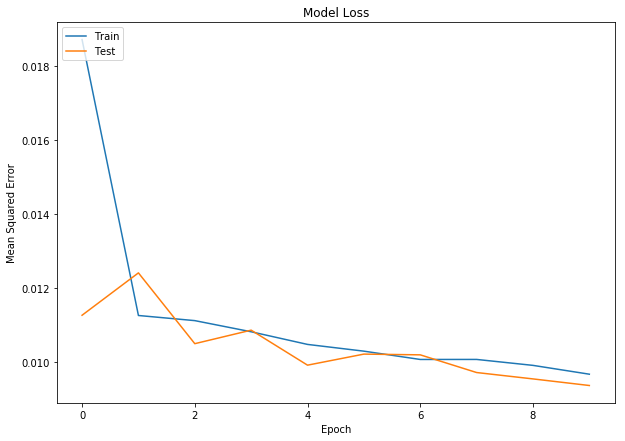

In [31]:
new_feature_list = ['BuildingArea', 'Rooms', 'Landsize', 'Car', 'Age'] + list(one_hot_region.columns)

run_neural_network(housing_df_feature[new_feature_list], housing_df_feature['Price'])

### *Assignment 9:*
- Check the original data to see if there are other features(columns) which might generate even better predictions if they are part of the model. 
- Write code below to add these new features and train a new network

In [ ]:
# CODE HERE